In [1]:
import re

import numpy as np
import pandas as pd

## Importing Datasets

In [2]:
string_df = pd.read_csv("../../data/interim/string_df.csv")

balanced_pairs_df = pd.read_csv("../../data/interim/balanced_pairs_df.csv", index_col=0)
balanced_pairs_df.drop_duplicates(inplace=True)
balanced_pairs_df.reset_index(drop=True, inplace=True)

In [3]:
string_df

,label,concatenated
0,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
1,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
2,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
3,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
4,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
...,...,...
951,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
952,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
953,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
954,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...


In [4]:
balanced_pairs_df

,Item 1,Item 2,Equality,device1,device2
0,580,648,1,XiaomiRedmi5_J,XiaomiRedmi5_J
1,793,840,1,XiaomiRedmi5_J,XiaomiRedmi5_J
2,814,838,1,XiaomiRedmi5_J,XiaomiRedmi5_J
3,773,866,1,XiaomiRedmi5_J,XiaomiRedmi5_J
4,640,798,1,XiaomiRedmi5_J,XiaomiRedmi5_J
...,...,...,...,...,...
3463,34,283,-1,SamsungS7_I,GooglePixel3A_L
3464,78,222,-1,iPhone12_W,GooglePixel3A_L
3465,342,454,-1,iPhone7_F,GooglePixel3A_L
3466,400,580,-1,GooglePixel3A_L,XiaomiRedmi5_J


## Importing Best Configurations

In [5]:
import re
import pandas as pd


def parse_log_file(filename):
    data = []

    with open(filename, "r") as file:
        lines = file.readlines()

        current_filter = None
        current_threshold = None
        current_min_error = None
        current_confidence = None

        for line in lines:
            if "Best Filter" in line:
                # Extract Best Filter using regex
                filter_match = re.search(r"Best Filter: (.+)", line)
                if filter_match:
                    current_filter = filter_match.group(1).strip()

            elif "Best Threshold" in line:
                # Extract Best Threshold using regex
                threshold_match = re.search(r"Best Threshold: (.+)", line)
                if threshold_match:
                    current_threshold = int(threshold_match.group(1).strip())

            elif "Min error" in line:
                # Extract Min Error using regex
                min_error_match = re.search(r"Min error: (.+)", line)
                if min_error_match:
                    current_min_error = float(min_error_match.group(1).strip())

            elif "Confidence" in line:
                # Extract Confidence using regex
                confidence_match = re.search(r"Confidence: (.+)", line)
                if confidence_match:
                    current_confidence = float(confidence_match.group(1).strip())

                    # Once we have all values, create a tuple and add it to the data list
                    data.append(
                        (
                            current_filter,
                            current_threshold,
                            current_min_error,
                            current_confidence,
                        )
                    )

                    # Reset current values for the next entry
                    current_filter = None
                    current_threshold = None
                    current_min_error = None
                    current_confidence = None

    # Convert the list of tuples into a DataFrame
    df = pd.DataFrame(
        data, columns=["Best Filter", "Best Threshold", "Min Error", "Confidence"]
    )

    return df

In [6]:
# Usage example:
filename = "../../reports/best_config"
best_configs_df = parse_log_file(filename)

In [7]:
best_configs_df

,Best Filter,Best Threshold,Min Error,Confidence
0,0[568] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1712],1,0.434833,0.262160
1,0[584] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1696],1,0.433483,0.267656
2,0[176] 🀫🀫🀫🀫🀫🀫🀫🀫 0[2104],2,0.435076,0.261171
3,0[2216] 🀆🀆🀆🀆🀫🀫🀫🀫 0[64],1,0.489039,0.043852


In [8]:
best_configs_df = best_configs_df.head(3)

## Generate Matrix

In [9]:
def convertColumntoArray(df: pd.DataFrame, column_name: str) -> np.array:
    return np.array([list(bstr) for bstr in df[column_name]])

In [10]:
def generateStringPairDf(pairs_df: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    # Convert the Probes column to a numpy array
    dataset_array = convertColumntoArray(dataset, "concatenated")

    return_df = pd.DataFrame()

    # Import the Probes into the pairs_df dataframe
    return_df["Item 1"] = pairs_df["Item 1"].apply(lambda index: dataset_array[index])
    return_df["Item 2"] = pairs_df["Item 2"].apply(lambda index: dataset_array[index])
    return_df["Equality"] = pairs_df["Equality"]

    return return_df

In [11]:
matrix_pairs_df = generateStringPairDf(balanced_pairs_df, string_df)
matrix_pairs_df.reset_index(inplace=True, drop=True)

## Filters Parser

In [12]:
def filter_parser(input_string: str) -> list:
    # Split the string into its parts
    parts = input_string.split()

    # Initialize the final array
    result = []

    # Process each part
    for part in parts:
        if part.startswith("0["):
            # Extract the number inside the brackets
            count = int(part[2:-1])
            # Append the corresponding number of zeros to the result
            result.extend([0] * count)
        else:
            # Translate the tiles to their respective values
            for char in part:
                if char == "🀆":
                    result.append(-1)
                elif char == "🀫":
                    result.append(1)

    return result

In [13]:
# import time

# time.sleep(100)

## Apply Filters

In [14]:
def apply_filter(item, filter):
    # item = np.array(list(item)).astype(int)
    item = item.astype(int)
    filter = filter_parser(filter)
    return np.sum(np.multiply(item, filter))

In [15]:
def apply_filter_threshold(item, filter, threshold) -> int:
    if apply_filter(item, filter) > threshold:
        return 1
    else:
        return -1

In [16]:
def apply_filter_threshold_pair(item_1, item_2, filter, threshold) -> int:
    if apply_filter_threshold(item_1, filter, threshold) == apply_filter_threshold(
        item_2, filter, threshold
    ):
        return 1
    else:
        return -1

## Calculate Fingerprint

In [17]:
def hamming_distance(array1, array2):
    # Check if arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Initialize distance counter
    distance = 0

    # Iterate through arrays and count differences
    for i in range(len(array1)):
        if array1[i] != array2[i]:
            distance += 1

    return distance

In [18]:
def calculate_fingerprint(item_1, item_2, best_filters, best_thresholds):
    fingerprint_1 = []
    fingerprint_2 = []

    for best_filter, best_threshold in zip(best_filters, best_thresholds):
        filtered_1 = np.sum(np.multiply(item_1.astype(int), filter_parser(best_filter)))
        filtered_2 = np.sum(np.multiply(item_2.astype(int), filter_parser(best_filter)))

        if filtered_1 > best_threshold:
            filtered_1 = 1
        else:
            filtered_1 = -1

        if filtered_2 > best_threshold:
            filtered_2 = 1
        else:
            filtered_2 = -1

        fingerprint_1.append(filtered_1)
        fingerprint_2.append(filtered_2)

        distance = hamming_distance(fingerprint_1, fingerprint_2)

    return distance

In [19]:
for i, row in matrix_pairs_df.iterrows():
    # Extracting best filters and thresholds from the main DataFrame (assuming same filters and thresholds for simplicity)
    best_filters = best_configs_df["Best Filter"].tolist()
    best_thresholds = best_configs_df["Best Threshold"].tolist()

    # Calculate the fingerprint using the relevant best filters and thresholds
    fingerprint = calculate_fingerprint(
        row["Item 1"], row["Item 2"], best_filters, best_thresholds
    )

    # Store the result in the 'distance' column (or any other processing you need)
    matrix_pairs_df.at[i, "h_distance"] = fingerprint

## Thresholding w/ $\tau$

In [20]:
taus = range(1, len(best_configs_df) + 1, 1)

In [21]:
for tau in taus:
    matrix_pairs_df[f"prediction_{tau}"] = np.where(
        matrix_pairs_df["h_distance"] < tau, 1, -1
    )

In [22]:
matrix_pairs_df

,Item 1,Item 2,Equality,h_distance,prediction_1,prediction_2,prediction_3
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,1.0,-1,1,1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,1.0,-1,1,1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,0.0,1,1,1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,1.0,-1,1,1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1,1.0,-1,1,1
...,...,...,...,...,...,...,...
3463,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,1.0,-1,1,1
3464,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",-1,0.0,1,1,1
3465,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,0.0,1,1,1
3466,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-1,2.0,-1,-1,1


## ROC

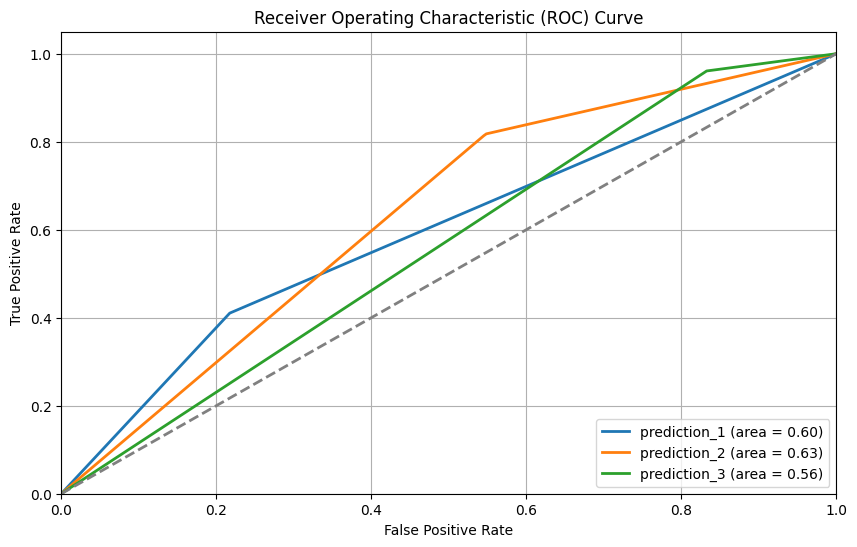

In [23]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Assuming matrix_pairs_df is your DataFrame
# True labels
y_true = matrix_pairs_df["Equality"]

plt.figure(figsize=(10, 6))

# Loop through each prediction column
for column in matrix_pairs_df.columns:
    if column.startswith("prediction_"):
        # Predicted scores
        y_scores = matrix_pairs_df[column]

        # Compute ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = roc_auc_score(y_true, y_scores)

        # Smooth the ROC curve using linear interpolation
        x_new = np.linspace(
            fpr.min(), fpr.max(), 300
        )  # Increase the number of points for smooth curve
        f = interp1d(fpr, tpr, kind="linear")  # Linear interpolation
        tpr_smooth = f(x_new)

        # Plot ROC curve
        plt.plot(x_new, tpr_smooth, lw=2, label=f"{column} (area = %0.2f)" % roc_auc)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)  # Add grid
plt.show()